In [5]:
import os

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [4]:
import cv2
import json
import matplotlib.pyplot as plt

In [23]:
import easyocr

In [3]:
from ultralytics import YOLO

d:\anaconda3\envs\yolov8_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model = YOLO('yolov8n.pt')

100%|██████████| 6.23M/6.23M [00:00<00:00, 16.5MB/s]


In [4]:
data_path = 'VietNam_License_Plate\data.yaml'

In [ ]:
model.train(
    data = data_path,
    epochs = 100,
    batch = 256,
    imgsz = 480,
    project = 'models',
    name = 'detect/train'
)

In [6]:
model = YOLO('models\detect\\train\weights\\best.pt')

In [11]:
model.val(
    data = data_path,
    imgsz = 480,
    project = 'models',
    name = 'detect/val'
)

Ultralytics YOLOv8.1.20 🚀 Python-3.8.18 torch-2.2.1 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 16380MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning D:\AIProject\VietNam_License_Plate_Detection_Using_YOLOv8\VietNam_License_Plate\valid\labels.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00, 10.38it/s]


                   all        200        200      0.999          1      0.995      0.783
Speed: 0.6ms preprocess, 2.4ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to models\detect\val2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002746A5C7EE0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

In [163]:
def process_result(result):

    int_to_char = {
        "6": "G",
        "0": "O"
    }
    char_to_int = {
        "g": "9",
        "L": "4",
        "Q": "0",
        "I": "1",
        "G": "6",
        "O": "0"
    }

    if len(result) == 1:
        text = list(result[0])
        for i in range(0, 2):
            if (text[i] in char_to_int.keys()):
                text[i] = char_to_int[text[i]]
        if (text[2] in int_to_char.keys()):
                text[2] = int_to_char[text[2]]
        for i in range(1, 6):
            if (text[-i] in char_to_int.keys()):
                text[-i] = char_to_int[text[-i]]
        result[0] = ''.join(text)
    if len(result) == 2:
        text = list(result[0])
        for i in range(0, 2):
            if (text[i] in char_to_int.keys()):
                text[i] = char_to_int[text[i]]
        if (text[2] in int_to_char.keys()):
                text[2] = int_to_char[text[2]]
        result[0] = ''.join(text)
        text = list(result[1])
        for i in range(0, len(text)):
            if (text[i] in char_to_int.keys()):
                text[i] = char_to_int[text[i]]
        result[1] = ''.join(text)
    
    if len(result) == 3:
        text = list(result[0])
        for i in range(0, 2):
            if (text[i] in char_to_int.keys()):
                text[i] = char_to_int[text[i]]
        text = list(result[2])
        for i in range(0, len(text)):
            if (text[i] in char_to_int.keys()):
                text[i] = char_to_int[text[i]]
        result[2] = ''.join(text)
    result = "-".join([res for res in result])
    result = result.replace("I", "1")
    return result


In [164]:
def extract_plate_text_easy_ocr(img, xmin, ymin, xmax, ymax):
    

    cropped_img = img[ymin:ymax, xmin:xmax]

    # Sử dụng EasyOCR để nhận dạng ký tự
    reader = easyocr.Reader(['en'])
    result = reader.readtext(cropped_img)
    result = [res[1] for res in result]
    plate_text = process_result(result)

    return plate_text

In [165]:
def visualize_plate(
        img_path, predictions,
        conf_thres=0.7,
        font = cv2.FONT_HERSHEY_SIMPLEX
):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]

    for prediction in predictions:
        conf_score = prediction['confidence']

        if conf_score < conf_thres:
            continue

        bbox = prediction['box']
        xmin = int(bbox['x1'])
        ymin = int(bbox['y1'])
        xmax = int(bbox['x2'])
        ymax = int(bbox['y2'])

        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

        text = extract_plate_text_easy_ocr(img, xmin, ymin, xmax, ymax)
        print(text)
        (text_width, text_height), _ = cv2.getTextSize(text, font, 1, 2)

        cv2.rectangle(
            img, 
            (xmin, ymin - text_height - 5), 
            (xmin + text_width, ymin),
            (0, 255, 0),
            -1
        )
        cv2.putText(img, text, (xmin, ymin - 5), font, 1, (0, 0, 0), 2)

    return img


image 1/1 d:\AIProject\VietNam_License_Plate_Detection_Using_YOLOv8\88888.jpg: 320x480 1 plate, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 480)
59-P1-888.88


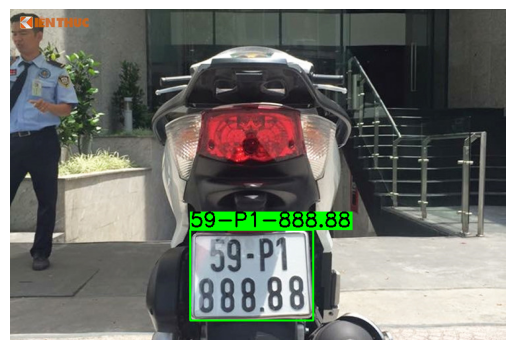

In [168]:
img_path  = '88888.jpg'
result = model.predict(img_path)
predictions = json.loads(result[0].tojson())
visualize_img = visualize_plate(img_path, predictions)

%matplotlib inline
plt.imshow(visualize_img)
plt.axis('off')
plt.show()